In [1]:
import sys
import numpy as np
from time import time
from pynq import Overlay
from pynq import allocate
from scipy.linalg import dft

In [14]:
ol=Overlay('DFT.bit')
SIZE = 1024
real_error=np.zeros(SIZE)
imag_error=np.zeros(SIZE)
ind=np.arange(SIZE)
real_rmse=np.zeros(SIZE)
imag_rmse=np.zeros(SIZE)
a = [i for i in range(SIZE)]
a=np.sin(a)+np.cos(a)
golden_op=np.fft.fft(a)
print(golden_op.real)
print(golden_op.imag)

[-0.0479323  -0.04793777 -0.04795417 ... -0.04798153 -0.04795417
 -0.04793777]
[ 0.          0.00114247  0.00228518 ... -0.00342836 -0.00228518
 -0.00114247]


In [15]:
#内存分配
in_real = allocate(shape=(SIZE,), dtype=np.float32) 
in_img = allocate(shape=(SIZE,), dtype=np.float32)           
out_real = allocate(shape=(SIZE,), dtype=np.float32) 
out_img = allocate(shape=(SIZE,), dtype=np.float32)
np.copyto(in_real, a.real)
np.copyto(in_img, a.imag)

DFT = ol.dft_0
start_time = time()

DFT.write(0x28, out_real.device_address)
DFT.write(0x34, out_img.device_address)
DFT.write(0x10, in_real.device_address)
DFT.write(0x1c, in_img.device_address)
DFT.write(0x00, 0x01)

while (DFT.read(0x00) & 0x4) == 0x0:
    continue
end_time = time()
print("耗时：: " + str(end_time - start_time) + " s")
print(out_real)
print(out_img)

耗时：: 0.037494659423828125 s
[-0.04793191 -0.04796153 -0.04795718 ... -0.04795682 -0.04795718
 -0.04796153]
[ 0.          0.00111404  0.00228716 ... -0.00339744 -0.00228716
 -0.00111404]


In [16]:
#计算RMS误差
for i in range(SIZE):
    real_error[i]="{}".format(abs(out_real[i]-golden_op.real[i]))
    imag_error[i]="{}".format(abs(out_img[i]-golden_op.imag[i]))
sum_sq_real=0
sum_sq_imag=0
for i in range(SIZE):
    sum_sq_real +=(real_error[i]*real_error[i])
    real_rmse = np.sqrt(sum_sq_real / (i+1))
    sum_sq_imag +=(imag_error[i]*imag_error[i])
    imag_rmse = np.sqrt(sum_sq_imag / (i+1))
print("Real RMSE: ", real_rmse, "Imag RMSE:", imag_rmse)    
if real_rmse < 0.001 and imag_rmse < 0.001:
    print("PASS")
else:
    print("FAIL")

Real RMSE:  1.857401163062513e-05 Imag RMSE: 1.1862265811441198e-05
PASS


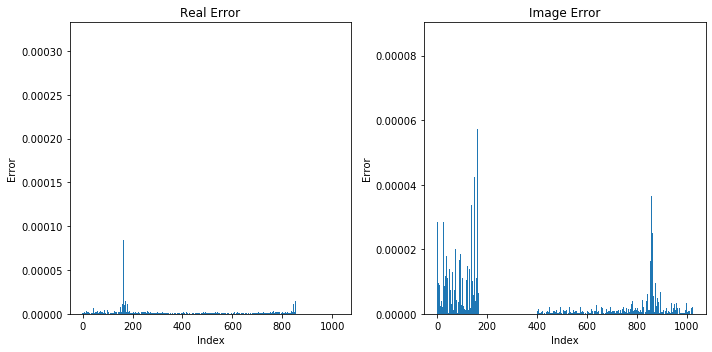

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.bar(ind,real_error)
plt.title("Real Error")
plt.xlabel("Index")
plt.ylabel("Error")
plt.tight_layout()

plt.subplot(1,2,2)
plt.bar(ind,imag_error)
plt.title("Image Error")
plt.xlabel("Index")
plt.ylabel("Error")
plt.tight_layout()

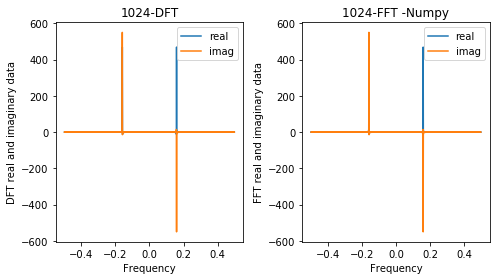

In [18]:
freq=np.fft.fftfreq(1024)

plt.figure(figsize=(7, 4))
plt.subplot(1,2,1)
plt.plot(freq,out_real,label='real')
plt.plot(freq,out_img,label='imag')
plt.title("1024-DFT")
plt.xlabel("Frequency")
plt.ylabel("DFT real and imaginary data")
plt.legend()
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(freq,golden_op.real,label='real')
plt.plot(freq,golden_op.imag,label='imag')
plt.title("1024-FFT -Numpy")
plt.xlabel("Frequency")
plt.ylabel("FFT real and imaginary data")
plt.legend()
plt.tight_layout()
plt.show()